In [1]:
import sys
sys.path.append('../../../src')

from common import common, transform, json
from group_activity import main as ga
from common.video import Capture, Writer
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

In [2]:
room_num = '09'
date = '20210304'

In [3]:
field_path = os.path.join(
    common.data_dir, '/{}/field0304.png'.format(room_num))

In [4]:
# homography
field_raw = cv2.imread(field_path)
p_video = transform.homo[room_num][0]
p_field = transform.homo[room_num][1]
homo_train = transform.Homography(p_video, p_field, field_raw.shape)

# Group Activity をロード

In [5]:
from common.json import GA_FORMAT
from group_activity.group_activity import GroupActivity

def make_group_activity(data, method):
    ga = GroupActivity(field_raw, method)
    ga.indicator_dict[method] = data[method]
    return ga

## 開始フレームと終了フレームを抽出する

In [6]:
name = 'pass1'
method = 'passing'
target_persons = {
    'pass1': [1, 2],
    'pass2': [0, 2],
    'pass3': [1, 2],
}

group_activity_json = os.path.join(
    common.data_dir, '/{0}/{1}/{2}/json/group_activity.json'.format(room_num, date, name))
group_activity_data = json.load(group_activity_json)

In [7]:
ga = make_group_activity(group_activity_data, method)

C:\Users\k2111\program\research\.venv\lib\site-packages\sklearn\base.py:324: UserWarning: Trying to unpickle estimator SVC from version 0.23.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [8]:
from common.json import GA_FORMAT

preds = []
pre_pred = 0
last_true_frame = 0
for data in ga.indicator_dict[method]:
    persons = data[GA_FORMAT[method][1]]
    if persons[0] in target_persons[name] and persons[1] in target_persons[name]:
        frame_num = data[GA_FORMAT[method][0]]
        pred = data[GA_FORMAT[method][3]]
        preds.append(pred)

        if pre_pred == 0 and pred == 1:
            if frame_num - last_true_frame < 50:
                print(last_true_frame)
                print(frame_num)
                # 20フレーム以内に 1 が来たら間を穴埋めする
                for i in range(last_true_frame, frame_num + 1):
                    preds[i] = 1

        if pred == 1:
            last_true_frame = frame_num
            
        pre_pred = pred

0
36
36
64
658
689


In [9]:
start_indices = []
end_indices = []

pre_pred = 0
for frame_num, pred in enumerate(preds):
    if pre_pred == 0 and pred == 1:
        start_indices.append(frame_num)
    elif pre_pred == 1 and pred == 0:
        end_indices.append(frame_num)
    
    pre_pred = pred

In [10]:
start_indices

[0, 512, 1078]

In [11]:
end_indices

[219, 846, 1710]

## タイムシーケンスを作る

In [12]:
width = 800
def make_sequence(preds, start_indices, end_indices, index, width=1200):
    fig = plt.figure(figsize=(width / 50.0, 1.0))
    ax = fig.add_subplot(
        111,
        xlim=(-10, len(preds) + 10), xticks=[],
        ylim=(-1.0, 1.0), yticks=[])
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)

    xlim = 10 / len(preds)
    ax.axhline(0, xmin=xlim, xmax=(1 - xlim))

    for start_index, end_index in zip(start_indices, end_indices):
        ax.axvspan(
            xmin=start_index, xmax=end_index,
            ymin=0.2, ymax=0.8,
            color='orange')
        
    ax.axvline(index, color='red')

    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.close(fig)

    # fig to ndarray
    fig.canvas.draw()
    result_image = np.array(fig.canvas.renderer.buffer_rgba())
    result_image = cv2.cvtColor(result_image, cv2.COLOR_RGBA2RGB)
    
    return result_image

## ビデオと合成する

In [13]:
def combine_image(frame_raw, result_image):
    frame = frame_raw.copy()
    ratio = 1 - (frame.shape[1] - result_image.shape[1]) / frame.shape[1]
    size = (int(frame.shape[1] * ratio), int(frame.shape[0] * ratio))
    frame = cv2.resize(frame, size)
    frame = np.concatenate([frame, result_image], axis=0)
    return frame

In [14]:
# load video
video_path = common.data_dir + '/{}/{}/{}/out/{}.mp4'.format(room_num, date, name, method)
capture = Capture(video_path)

# out video file path
out_path = common.data_dir + '/{}/{}/{}/out/{}_result.mp4'.format(room_num, date, name, method)

frames = []
for frame_num in tqdm(range(capture.frame_num)):
    # read frame
    frame_raw = capture.read()
    
    result_image = make_sequence(preds, start_indices, end_indices, frame_num)

    # append tracking result
    img = combine_image(frame_raw, result_image)
    frames.append(img)
    
print('writing videos into {} ...'.format(out_path))
writer = Writer(out_path, capture.fps, frames[0].shape[1::-1])
writer.write(frames)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1782/1782 [00:43<00:00, 41.10it/s]


writing videos into C:\Users\k2111\program\research\data/09/20210304/pass1/out/passing_result.mp4 ...


In [15]:
figsize = (np.array(frames[0].shape[:2]) * 0.01)[1::-1]
image_dir = '../images/'

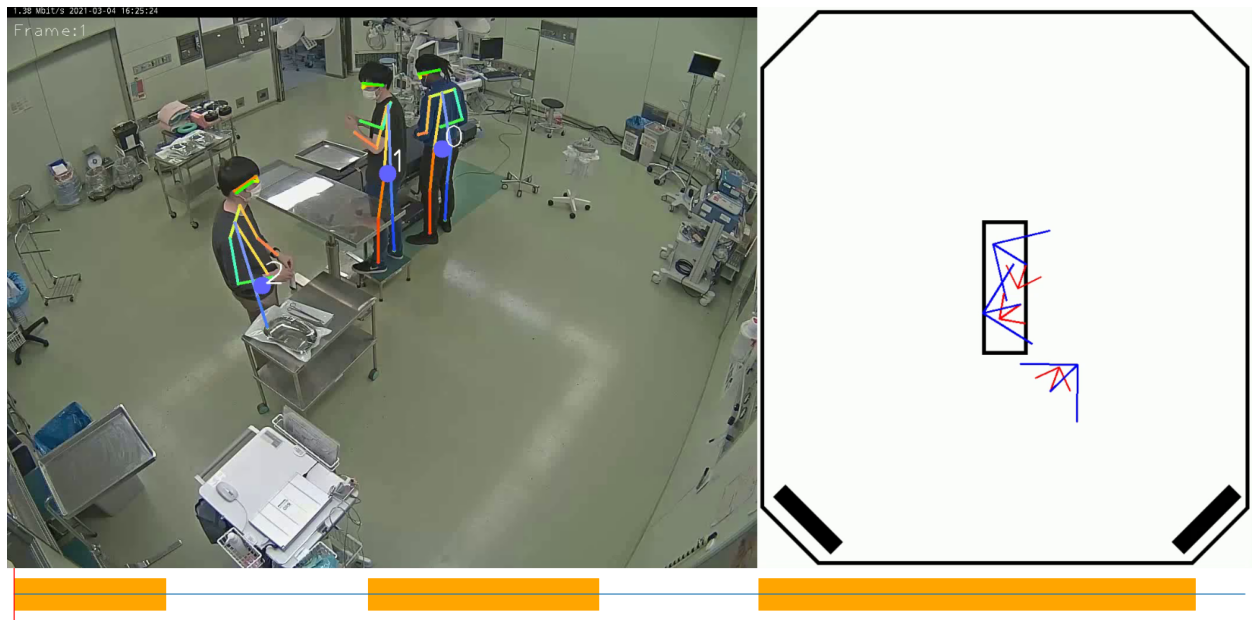

In [17]:
plt.figure(figsize=figsize)
plt.imshow(frames[start_indices[0]])
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xticks([])
plt.yticks([])
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
# plt.savefig(image_dir + 'small.pdf')

In [ ]:
plt.figure(figsize=figsize)
plt.imshow(frames[start_indices[1]])
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xticks([])
plt.yticks([])
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
# plt.savefig(image_dir + 'mdeium.pdf')

In [ ]:
plt.figure(figsize=figsize)
plt.imshow(frames[start_indices[2]])
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xticks([])
plt.yticks([])
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
# plt.savefig(image_dir + 'large.pdf')

In [ ]:
plt.figure(figsize=figsize)
plt.imshow(frames[790])
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xticks([])
plt.yticks([])
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
# plt.savefig(image_dir + 'result.pdf')